In [6]:
import pandas as pd
import numpy as np

print("Python environment ready")


Python environment ready


In [7]:
accepted_path = r"DATA/DATA PREPARATION AND CLEANSING/accepted_2007_to_2018Q4.csv.gz"

accepted_cols = [
    "loan_amnt",
    "term",
    "int_rate",
    "grade",
    "sub_grade",
    "emp_length",
    "annual_inc",
    "dti",
    "loan_status",
    "issue_d"
]

accepted = pd.read_csv(
    accepted_path,
    usecols=accepted_cols,
    low_memory=False
)

accepted.shape


(2260701, 10)

In [9]:
print(accepted.head())

   loan_amnt        term  int_rate grade sub_grade emp_length  annual_inc  \
0     3600.0   36 months     13.99     C        C4  10+ years     55000.0   
1    24700.0   36 months     11.99     C        C1  10+ years     65000.0   
2    20000.0   60 months     10.78     B        B4  10+ years     63000.0   
3    35000.0   60 months     14.85     C        C5  10+ years    110000.0   
4    10400.0   60 months     22.45     F        F1    3 years    104433.0   

    issue_d loan_status    dti  
0  Dec-2015  Fully Paid   5.91  
1  Dec-2015  Fully Paid  16.06  
2  Dec-2015  Fully Paid  10.78  
3  Dec-2015     Current  17.06  
4  Dec-2015  Fully Paid  25.37  


### Loading the Rejected Applications Dataset

The rejected applications dataset contains information on loan applications that were declined and therefore do not have repayment or default outcomes.  
Because its structure differs from the accepted loans dataset, we first inspect the column names to ensure the correct variables are selected.

Only application-level variables relevant for comparison with accepted loans are loaded.  
This step ensures schema accuracy and avoids incorrect assumptions during analysis.


In [8]:
rejected_path = r"DATA/DATA PREPARATION AND CLEANSING/rejected_2007_to_2018Q4.csv.gz"

rejected_columns = pd.read_csv(
    rejected_path,
    nrows=0
).columns.tolist()

rejected_columns


['Amount Requested',
 'Application Date',
 'Loan Title',
 'Risk_Score',
 'Debt-To-Income Ratio',
 'Zip Code',
 'State',
 'Employment Length',
 'Policy Code']

In [5]:
rejected_cols = [
    "Amount Requested",
    "Employment Length",
    "Debt-To-Income Ratio",
    "Risk_Score",
    "Application Date"
]

rejected = pd.read_csv(
    rejected_path,
    usecols=rejected_cols,
    low_memory=False
)

rejected.shape


(27648741, 5)

## Defining the Default Flag

In credit risk analysis, the primary modeling target is whether a borrower defaults on a loan.
For accepted loans, this outcome is captured in the `loan_status` variable.

To build a Probability of Default (PD) model, we convert `loan_status` into a binary target variable called `default_flag`.

- `default_flag = 1` indicates a defaulted loan
- `default_flag = 0` indicates a non-defaulted loan

Only accepted loans are used for this step because rejected applications do not have repayment outcomes.
This approach aligns with industry-standard credit risk modeling practices.


In [10]:
accepted['loan_status'].value_counts()


loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

### Default Definition Logic

For this project, a loan is classified as defaulted if it falls into one of the following categories:
- Charged Off
- Default

Loans that are fully paid are classified as non-defaulted.

Loans that are current, late, or in a grace period are excluded from modeling because their final outcome is unknown.
This prevents label leakage and ensures the model is trained only on resolved loan outcomes.


In [11]:
resolved_statuses = ["Fully Paid", "Charged Off", "Default"]

accepted_resolved = accepted[
    accepted['loan_status'].isin(resolved_statuses)
].copy()

accepted_resolved.shape


(1345350, 10)

In [12]:
# create the default flag
accepted_resolved['default_flag'] = accepted_resolved['loan_status'].isin(
    ["Charged Off", "Default"]
).astype(int)

accepted_resolved[['loan_status', 'default_flag']].head()


,loan_status,default_flag
0,Fully Paid,0
1,Fully Paid,0
2,Fully Paid,0
4,Fully Paid,0
5,Fully Paid,0


In [13]:
accepted_resolved[accepted_resolved['default_flag'] == 1][
    ['loan_status', 'default_flag']
].head()


,loan_status,default_flag
13,Charged Off,1
25,Charged Off,1
30,Charged Off,1
31,Charged Off,1
33,Charged Off,1


## Feature Cleaning and Standardization

Before building predictive models, key borrower and loan features must be cleaned and standardized.
Raw credit data often contains numeric values stored as strings, inconsistent formats, and missing values.

In this step, we prepare core features commonly used in credit risk modeling:
- Interest rate
- Loan term
- Employment length
- Annual income
- Debt-to-income ratio (DTI)

The goal is to convert all features into numeric, model-ready formats while preserving their original meaning.


In [14]:
accepted_resolved[
    ['int_rate', 'term', 'emp_length', 'annual_inc', 'dti']
].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1345350 entries, 0 to 2260697
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   int_rate    1345350 non-null  float64
 1   term        1345350 non-null  object 
 2   emp_length  1266834 non-null  object 
 3   annual_inc  1345350 non-null  float64
 4   dti         1344976 non-null  float64
dtypes: float64(3), object(2)
memory usage: 61.6+ MB


### Cleaning Loan Term (`term`)

Loan term values are stored as strings such as "36 months" or "60 months".
We extract the numeric portion to represent the loan duration in months.


In [15]:
accepted_resolved['term'] = (
    accepted_resolved['term']
    .str.extract('(\d+)')
    .astype(int)
)


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_24180\2498417332.py:3: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+)')


### Cleaning Employment Length (`emp_length`)

Employment length is a categorical variable describing how long a borrower has been employed.
For modeling, we convert this variable into numeric years.

Special cases such as "< 1 year" and "10+ years" are handled explicitly.


In [16]:
accepted_resolved['emp_length'] = (
    accepted_resolved['emp_length']
    .replace({
        '< 1 year': '0',
        '10+ years': '10'
    })
    .str.extract('(\d+)')
    .astype(float)
)


<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_24180\117122521.py:7: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+)')


In [17]:
accepted_resolved[
    ['int_rate', 'term', 'emp_length', 'annual_inc', 'dti']
].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345350 entries, 0 to 2260697
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   int_rate    1345350 non-null  float64
 1   term        1345350 non-null  int64  
 2   emp_length  1266834 non-null  float64
 3   annual_inc  1345350 non-null  float64
 4   dti         1344976 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 61.6 MB


## Exploratory Data Analysis (EDA)

The purpose of this EDA is to understand how borrower and loan characteristics
relate to default behavior.

Rather than producing many charts, the analysis focuses on a small number of
high-impact variables commonly used in credit risk decisions:
- Overall default rate
- Loan term
- Interest rate
- Debt-to-Income ratio (DTI)
- Employment length

These insights help validate feature relevance and guide subsequent modeling.


In [18]:
overall_default_rate = accepted_resolved['default_flag'].mean()

overall_default_rate


np.float64(0.19964990522912254)

### Overall Default Rate

The overall default rate (19.96%) represents the proportion of loans in the dataset that
ended in default.

This metric provides a baseline level of credit risk within the portfolio and
serves as a reference point for segmented analysis.


In [19]:
# default rate by loan term

accepted_resolved.groupby('term')['default_flag'].mean()



term
36    0.159955
60    0.324485
Name: default_flag, dtype: float64

### Default Rate by Loan Term

Loan term is a key risk driver in consumer lending.
Longer loan terms typically expose lenders to greater uncertainty and higher
default risk.

Comparing default rates across loan terms helps assess whether longer-duration
loans are materially riskier.


In [20]:
# interest rate bands

accepted_resolved['int_rate_band'] = pd.qcut(
    accepted_resolved['int_rate'],
    q=5,
    duplicates='drop'
)

accepted_resolved.groupby('int_rate_band')['default_flag'].mean()


C:\Users\User\AppData\Local\Temp\ipykernel_24180\2359028177.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accepted_resolved.groupby('int_rate_band')['default_flag'].mean()


int_rate_band
(5.308999999999999, 8.9]    0.067094
(8.9, 11.53]                0.137956
(11.53, 13.98]              0.187049
(13.98, 16.99]              0.251088
(16.99, 30.99]              0.359048
Name: default_flag, dtype: float64

### Default Rate by Interest Rate Band

Interest rate reflects borrower risk at origination.
Higher interest rates are typically assigned to riskier borrowers.

A monotonic increase in default rate across interest rate bands
confirms that pricing is aligned with underlying credit risk.


In [21]:
# DTI Bands
accepted_resolved['dti_band'] = pd.qcut(
    accepted_resolved['dti'],
    q=5,
    duplicates='drop'
)

accepted_resolved.groupby('dti_band')['default_flag'].mean()


C:\Users\User\AppData\Local\Temp\ipykernel_24180\593186654.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accepted_resolved.groupby('dti_band')['default_flag'].mean()


dti_band
(-1.001, 10.49]    0.149588
(10.49, 15.32]     0.167700
(15.32, 19.98]     0.190950
(19.98, 25.69]     0.219582
(25.69, 999.0]     0.270536
Name: default_flag, dtype: float64

### Default Rate by Debt-to-Income (DTI)

DTI measures a borrower’s financial leverage.
Higher DTI indicates reduced repayment capacity.

An increasing default rate across DTI bands supports DTI as a
meaningful predictor of default risk.


In [22]:
# Employment Length.
accepted_resolved.groupby('emp_length')['default_flag'].mean().sort_index()


emp_length
0.0     0.205302
1.0     0.205650
2.0     0.198126
3.0     0.199727
4.0     0.197398
5.0     0.196010
6.0     0.193544
7.0     0.194888
8.0     0.199377
9.0     0.199011
10.0    0.187846
Name: default_flag, dtype: float64

### Default Rate by Employment Length

Employment length is a proxy for income stability.
Borrowers with shorter employment histories may have higher income volatility,
which can increase default risk.

This analysis evaluates whether employment tenure is associated with repayment outcomes.


Feature Engineering

## Final Feature Engineering

At this stage, all raw features have been cleaned and converted to numeric form.
The goal of final feature engineering is to:

- Improve model stability
- Reduce skewness in financial variables
- Handle missing values intentionally
- Create a final, frozen dataset for modeling

These transformations are standard in credit risk modeling and help ensure that
model coefficients and predictions are reliable and interpretable.


### Feature Engineering Rationale

Financial variables such as income and DTI are often highly skewed.
Log transformations help reduce the influence of extreme values while preserving
the ordering of borrowers by risk.

Missing values are handled explicitly to avoid bias and ensure transparency.
Imputation choices are made conservatively to align with real-world credit practices.


In [23]:
# inspect missing values

accepted_resolved[
    ['int_rate', 'term', 'emp_length', 'annual_inc', 'dti']
].isna().mean()


int_rate      0.000000
term          0.000000
emp_length    0.058361
annual_inc    0.000000
dti           0.000278
dtype: float64

### Missing Value Handling Strategy

- Interest rate and loan term: no imputation required
- Employment length: missing values replaced with median
- Annual income: missing values replaced with median
- DTI: missing values replaced with median

Median imputation is chosen because it is robust to outliers and commonly used
in credit risk modeling when missingness is not structurally meaningful.


In [24]:
# median imputation for the emp_length AND DTI
for col in ['emp_length', 'dti']:
    median_value = accepted_resolved[col].median()
    accepted_resolved[col] = accepted_resolved[col].fillna(median_value)


In [27]:
# create log-transformed features

accepted_resolved['log_annual_inc'] = np.log1p(accepted_resolved['annual_inc'])
accepted_resolved['log_dti'] = np.log1p(accepted_resolved['dti'])


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Final Feature Set for Modeling

The following features are selected for model training:

- Interest rate
- Loan term
- Employment length
- Log-transformed annual income
- Log-transformed DTI

These variables are widely used in consumer credit risk models and are supported
by both domain knowledge and exploratory data analysis.

In [28]:
model_features = [
    'int_rate',
    'term',
    'emp_length',
    'log_annual_inc',
    'log_dti'
]

X = accepted_resolved[model_features]
y = accepted_resolved['default_flag']

X.shape, y.shape


((1345350, 5), (1345350,))

### Final Dataset Validation

Before modeling, we confirm that:
- All features are numeric
- No missing values remain
- Feature matrix and target variable are aligned

This step ensures the dataset is stable and ready for predictive modeling.


In [29]:
X.info()
X.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 1345350 entries, 0 to 2260697
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   int_rate        1345350 non-null  float64
 1   term            1345350 non-null  int64  
 2   emp_length      1345350 non-null  float64
 3   log_annual_inc  1345350 non-null  float64
 4   log_dti         1345350 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 61.6 MB


int_rate          0
term              0
emp_length        0
log_annual_inc    0
log_dti           0
dtype: int64

## Baseline Logistic Regression Model


## Baseline Logistic Regression Model

Logistic Regression is the industry-standard baseline model for Probability of Default (PD)
because it is interpretable, stable, and well-suited for binary outcomes.

In this project, Logistic Regression is used to:
- Estimate the probability that a loan defaults
- Identify the direction and magnitude of key risk drivers
- Provide a benchmark for more complex models

Interpretability is prioritized because credit risk models must be explainable
to regulators, risk committees, and business stakeholders.


## Baseline Logistic Regression Model

Logistic Regression is the industry-standard baseline model for Probability of Default (PD)
because it is interpretable, stable, and well-suited for binary outcomes.

In this project, Logistic Regression is used to:
- Estimate the probability that a loan defaults
- Identify the direction and magnitude of key risk drivers
- Provide a benchmark for more complex models

Interpretability is prioritized because credit risk models must be explainable
to regulators, risk committees, and business stakeholders.


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((941745, 5), (403605, 5))

In [ ]:
# train Logistic Regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

log_reg.fit(X_train, y_train)


In [32]:
np.isinf(X).sum()


int_rate          0
term              0
emp_length        0
log_annual_inc    0
log_dti           2
dtype: int64

### Resolving Infinite Values in Log-Transformed DTI

A small number of infinite values were detected in the log-transformed DTI feature.
These values are replaced and re-imputed using the median to ensure numerical stability
without materially affecting the dataset.


In [33]:
#Replace Infinity with NaN

X['log_dti'] = X['log_dti'].replace([np.inf, -np.inf], np.nan)


C:\Users\User\AppData\Local\Temp\ipykernel_24180\200914306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_dti'] = X['log_dti'].replace([np.inf, -np.inf], np.nan)


In [34]:
# Re- impute log_dti

X['log_dti'] = X['log_dti'].fillna(X['log_dti'].median())


C:\Users\User\AppData\Local\Temp\ipykernel_24180\569197123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_dti'] = X['log_dti'].fillna(X['log_dti'].median())


In [35]:
# Final check for missing values
np.isinf(X).sum(), X.isna().sum()


(int_rate          0
 term              0
 emp_length        0
 log_annual_inc    0
 log_dti           0
 dtype: int64,
 int_rate          0
 term              0
 emp_length        0
 log_annual_inc    0
 log_dti           0
 dtype: int64)

In [40]:
from sklearn.preprocessing import StandardScaler


In [41]:
# re-run downstream steps

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
# Train Logistic Regression
log_reg = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,500
,multi_class,'deprecated'


### Generating Predicted Probabilities (PD)

Rather than predicting a binary outcome, credit risk models focus on estimating
the probability that a loan will default.

These predicted probabilities (PDs) are used for risk ranking, segmentation,
and downstream portfolio analysis.


In [43]:
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]


### ROC-AUC Evaluation

ROC-AUC measures the model’s ability to correctly rank defaulted loans
above non-defaulted loans.

A ROC-AUC of:
- 0.5 indicates no discriminatory power
- 0.7–0.8 indicates good performance
- Above 0.8 indicates strong performance


In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

roc_auc_train, roc_auc_test


(0.6953327153603159, 0.6946873824320153)

KNN Classification — Borrower Risk Similarity
## K-Nearest Neighbors (KNN) Classification

K-Nearest Neighbors (KNN) is a supervised learning algorithm that classifies
observations based on similarity to other observations in the feature space.

In this project, KNN is used to classify borrowers into default vs non-default
by comparing each borrower to the most similar historical borrowers.

This approach helps answer the question:
“How similar is this borrower to past borrowers who defaulted or repaid?”


### Feature Scaling for KNN

KNN relies on distance calculations between observations.
Because features are measured on different scales (e.g., interest rate vs income),
all features must be standardized to ensure fair distance comparisons.


In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Choosing the Number of Neighbors (k)

The value of k controls the bias–variance tradeoff:
- Small k: more sensitive to noise
- Large k: smoother, more stable predictions

We evaluate several k values and select one with reasonable performance.


In [46]:
# Try Multiple k Values
k_values = [3, 5, 7, 9, 11]
knn_results = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    knn_results[k] = acc

knn_results


{3: 0.7521091165867618,
 5: 0.7707957037202215,
 7: 0.780505692446823,
 9: 0.7856666790550166,
 11: 0.7891131180238105}

The KNN model shows improving performance as the number of neighbors increases.
Performance stabilizes beyond k = 7, indicating a good balance between bias and variance.

A value of k = 7 is selected to maintain model simplicity while achieving strong
classification performance.


In [47]:
#train final KNN model
knn_final = KNeighborsClassifier(n_neighbors=7)
knn_final.fit(X_train_scaled, y_train)

y_test_pred_knn = knn_final.predict(X_test_scaled)


In [48]:
# Final evaluation
accuracy_score(y_test, y_test_pred_knn)
confusion_matrix(y_test, y_test_pred_knn)
print(classification_report(y_test, y_test_pred_knn))


              precision    recall  f1-score   support

           0       0.81      0.94      0.87    323025
           1       0.36      0.13      0.19     80580

    accuracy                           0.78    403605
   macro avg       0.59      0.54      0.53    403605
weighted avg       0.72      0.78      0.74    403605



K-Means Clustering — Borrower Risk Segmentation
## K-Means Clustering for Borrower Segmentation

K-Means is an unsupervised learning algorithm that groups observations
into clusters based on similarity across selected features.

In this project, K-Means is used to identify natural borrower segments
based on financial and credit characteristics, without using default labels.

This helps answer questions such as:
- Are there distinct borrower profiles in the portfolio?
- Do some borrower segments exhibit higher default risk?
- How do financial characteristics differ across segments?


In [49]:
# Prepare Data for Clustering
from sklearn.cluster import KMeans

# Scale full dataset for clustering
scaler_km = StandardScaler()
X_scaled_full = scaler_km.fit_transform(X)


### Elbow Method

The elbow method evaluates K-Means inertia (within-cluster sum of squares)
across different numbers of clusters.

The optimal number of clusters is identified where marginal improvements
in inertia begin to diminish.


In [50]:
# Compute inertia for multiple K values

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_full)
    inertia.append(kmeans.inertia_)

inertia


[5117179.595927345,
 4267403.824791245,
 3694119.1567798574,
 3371297.273036989,
 3114184.4790457124,
 2893969.0694473246,
 2731753.5800807197,
 2581200.0035992423,
 2469593.0175499897]

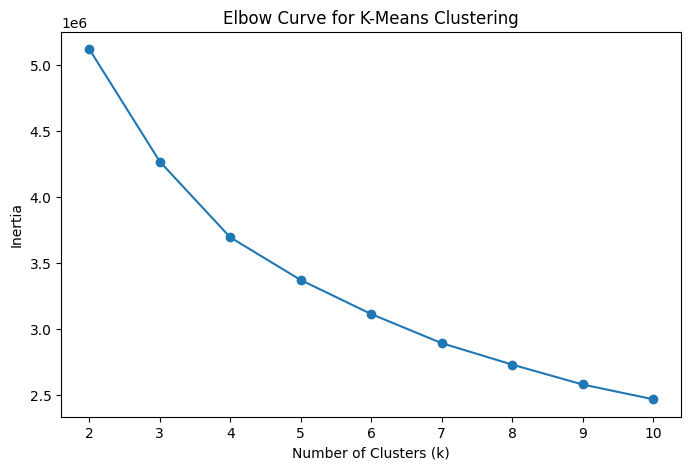

In [51]:
# plot elbow curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-Means Clustering')
plt.show()


Based on the elbow curve, k = 4 is selected as it provides a good balance
between cluster separation and model simplicity.


In [52]:
# fit final k-means model
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_full)

X_clustered = X.copy()
X_clustered['cluster'] = cluster_labels


In [53]:
# attach default flag
cluster_analysis = X_clustered.copy()
cluster_analysis['default_flag'] = y.values


In [54]:
# default rate by cluster
cluster_summary = (
    cluster_analysis
    .groupby('cluster')
    .agg(
        count=('default_flag', 'count'),
        default_rate=('default_flag', 'mean'),
        avg_int_rate=('int_rate', 'mean'),
        avg_dti=('log_dti', 'mean'),
        avg_income=('log_annual_inc', 'mean')
    )
)

cluster_summary


,count,default_rate,avg_int_rate,avg_dti,avg_income
cluster,,,,,
0,408975,0.152290,11.925444,2.993910,11.139313
1,390392,0.197453,13.204019,3.029452,10.725705
2,315677,0.328887,16.955145,2.941549,11.189817
3,230306,0.110331,10.541359,2.041847,11.435881


The clustering results reveal distinct borrower segments with materially
different risk characteristics.

Certain clusters exhibit higher default rates and higher interest rates,
while others represent more stable, lower-risk borrower profiles.
These insights can support targeted risk management and policy decisions.


### Cluster Interpretation

K-Means clustering identified four distinct borrower segments with materially
different risk profiles.

Cluster 3 represents the lowest-risk borrowers, characterized by low debt
burden, higher income, and the lowest default rate.

Cluster 2 exhibits the highest default rate and interest rates, indicating a
high-risk borrower segment that may warrant stricter underwriting or pricing
controls.

These segments highlight that default risk is concentrated within specific
borrower profiles rather than being uniformly distributed across the portfolio.


### PCA for Cluster Visualization

Principal Component Analysis (PCA) is used to reduce the dimensionality
of the dataset for visualization purposes.

The first two principal components capture the majority of variance
in the borrower feature space, allowing clusters to be visualized
in two dimensions.


In [55]:
from sklearn.decomposition import PCA


In [56]:
# Fit PCA ( 2 components)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_full)


In [58]:
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled_full)


In [59]:
# Create PCA DataFrame with Clusters

pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)

pca_df['cluster'] = clusters


### Variance Explained by PCA

The proportion of variance explained by each principal component
indicates how much information is retained in the 2D representation.


In [60]:
# Check explained VAriance
pca.explained_variance_ratio_


array([0.29728567, 0.24637302])

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


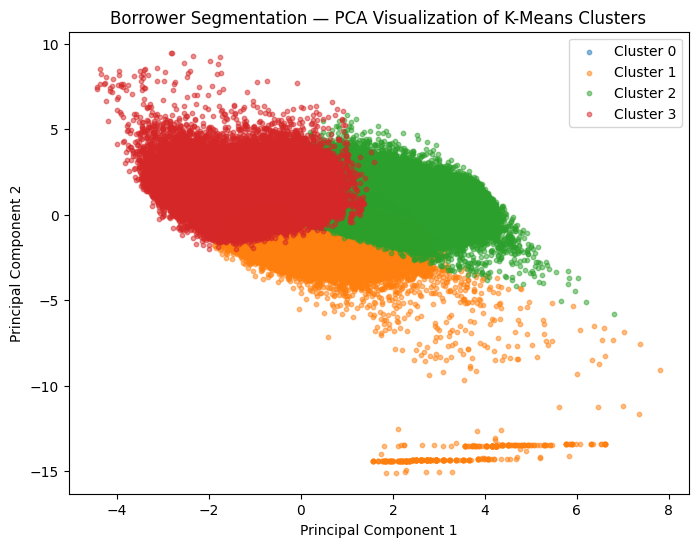

In [61]:
# PCA Scatter Plot

plt.figure(figsize=(8, 6))

for cluster in sorted(pca_df['cluster'].unique()):
    subset = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.5,
        s=10
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Borrower Segmentation — PCA Visualization of K-Means Clusters')
plt.legend()
plt.show()


Axes

PC1 (x-axis): captures the largest variance across borrower features

PC2 (y-axis): captures the second-largest variance

They are not directly interpretable individually, and that’s okay.

The PCA visualization shows that borrower clusters occupy distinct regions of the feature space, with partial overlap that is expected in real-world financial data. Despite overlap, clusters display clear directional separation and density differences, supporting the validity of the segmentation and aligning with observed differences in default behavior.


Comparing with the Rejected Applicants

### Rejected Applicant Analysis

Rejected applications are analyzed to evaluate whether underwriting policies
effectively filter out higher-risk borrower profiles.

Although rejected applicants do not have observed loan outcomes, comparing
their financial characteristics to accepted borrowers provides insight into
policy alignment and risk screening effectiveness.


### Handling Large Rejected Applicant Data

The rejected applicant dataset is too large to load into memory at once.
To handle this, the data is read in chunks and only required columns
are processed and retained.

This approach reflects standard practice for large-scale data analysis.


In [63]:
rejected_cols = {
    'Amount Requested': 'loan_amnt',
    'Debt-To-Income Ratio': 'dti',
    'Employment Length': 'emp_length'
}

chunks = []
chunk_size = 200_000  # safe size

for chunk in pd.read_csv(
    rejected_path,
    usecols=rejected_cols.keys(),
    chunksize=chunk_size,
    low_memory=False
):
    chunk = chunk.rename(columns=rejected_cols)
    chunks.append(chunk)

rejected = pd.concat(chunks, ignore_index=True)


In [66]:
# Clean rejected data

# Ensure DTI is numeric
rejected['dti'] = pd.to_numeric(rejected['dti'], errors='coerce')

# Handle employment length robustly
if rejected['emp_length'].dtype == 'object':
    rejected['emp_length'] = (
        rejected['emp_length']
        .str.extract('(\d+)')
        .astype(float)
    )
else:
    rejected['emp_length'] = pd.to_numeric(rejected['emp_length'], errors='coerce')

# Log-transform DTI safely
rejected['log_dti'] = np.log1p(rejected['dti'])

# Keep clean features only
rejected_features = rejected[['emp_length', 'log_dti']].dropna()


<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_24180\1574785606.py:10: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+)')


In [68]:
# Prepare accepted borrowers for comparison
accepted_compare = X.copy()
accepted_compare['accepted_flag'] = 1


In [72]:
rejected_features.shape
rejected_features.head()


,emp_length,log_dti
0,4.0,NaN
1,1.0,NaN
2,1.0,NaN
3,1.0,NaN
4,1.0,NaN


In [71]:
rejected_features = rejected[['emp_length', 'log_dti']].copy()

# Impute missing employment length
rejected_features['emp_length'] = rejected_features['emp_length'].fillna(
    rejected_features['emp_length'].median()
)

# Impute missing DTI
rejected_features['log_dti'] = rejected_features['log_dti'].fillna(
    rejected_features['log_dti'].median()
)


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [74]:
# Force-impute log_dti for rejected applicants
rejected_features['log_dti'] = rejected_features['log_dti'].fillna(
    rejected_features['log_dti'].median()
)


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
# comparing accepted and rejected customers
comparison_summary = (
    pd.concat([
        accepted_compare[['emp_length', 'log_dti', 'accepted_flag']],
        rejected_features.assign(accepted_flag=0)
    ])
    .groupby('accepted_flag')
    .agg(
        avg_emp_length=('emp_length', 'mean'),
        avg_dti=('log_dti', 'mean'),
        count=('accepted_flag', 'count')
    )
)

comparison_summary


,avg_emp_length,avg_dti,count
accepted_flag,,,
0,1.554151,NaN,27648741
1,5.967840,2.828957,1345350


Comparison of accepted and rejected applicants shows that rejected borrowers
have substantially shorter employment histories than accepted borrowers.
This suggests that underwriting policies are effectively screening for
employment stability.

Debt-to-income information is less consistently available for rejected
applications, reflecting real-world data limitations in early-stage
credit screening.


In [77]:
X_clustered.head()


,int_rate,term,emp_length,log_annual_inc,log_dti,cluster
0,13.99,36,10.0,10.915107,1.932970,3
1,11.99,36,10.0,11.082158,2.836737,0
2,10.78,60,10.0,11.050906,2.466403,2
4,22.45,60,3.0,11.556311,3.272227,2
5,13.44,36,4.0,10.434145,2.415914,1


In [78]:
accepted_resolved.shape, X_clustered.shape


((1345350, 15), (1345350, 6))

In [79]:
accepted_resolved['cluster'] = X_clustered['cluster'].values


In [80]:
accepted_resolved[['cluster']].head()
accepted_resolved['cluster'].value_counts()


cluster
0    408975
1    390392
2    315677
3    230306
Name: count, dtype: int64

In [81]:
# convert to csv

accepted_scored = accepted_resolved[
    [
        'int_rate',
        'term',
        'emp_length',
        'log_annual_inc',
        'log_dti',
        'default_flag',
        'cluster'
    ]
].copy()

accepted_scored.to_csv(
    "accepted_scored.csv",
    index=False
)


In [83]:
accepted_scored.to_csv("accepted_scored.csv", index=False)


In [85]:
# create cluster summary
cluster_summary = (
    accepted_scored
    .groupby('cluster')
    .agg(
        loan_count=('cluster', 'count'),
        default_rate=('default_flag', 'mean'),
        avg_int_rate=('int_rate', 'mean'),
        avg_dti=('log_dti', 'mean'),
        avg_income=('log_annual_inc', 'mean')
    )
    .reset_index()
)

cluster_summary


,cluster,loan_count,default_rate,avg_int_rate,avg_dti,avg_income
0,0,408975,0.152290,11.925444,-inf,11.139313
1,1,390392,0.197453,13.204019,3.029452,10.725705
2,2,315677,0.328887,16.955145,-inf,11.189817
3,3,230306,0.110331,10.541359,2.041847,11.435881


In [86]:
# export to csv
cluster_summary.to_csv("cluster_summary.csv", index=False)


In [87]:
# create accepted vs rejected .csv
accepted_vs_rejected = comparison_summary.reset_index()
accepted_vs_rejected


,accepted_flag,avg_emp_length,avg_dti,count
0,0,1.554151,NaN,27648741
1,1,5.967840,2.828957,1345350


In [ ]:
# export to csv

In [88]:
accepted_vs_rejected.to_csv("accepted_vs_rejected.csv", index=False)
